<a href="https://colab.research.google.com/github/Cimbir/Store-Sales-Forecasting/blob/main/model_sarima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir ~/.kaggle
!echo "{\"username\":\"dachisuramelashvili\",\"key\":\"4202ec60e20b612a9947450bb8aeebb5\"}" > ~/.kaggle
!cp /content/drive/MyDrive/ML/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
/bin/bash: line 1: /root/.kaggle: Is a directory


In [ ]:
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting
!unzip walmart-recruiting-store-sales-forecasting.zip

walmart-recruiting-store-sales-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  walmart-recruiting-store-sales-forecasting.zip
replace features.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace sampleSubmission.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace stores.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
!unzip train.csv.zip
!unzip stores.csv.zip
!unzip features.csv.zip

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
unzip:  cannot find or open stores.csv.zip, stores.csv.zip.zip or stores.csv.zip.ZIP.
Archive:  features.csv.zip
replace features.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

# Get Data

In [ ]:
train = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')

In [ ]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [ ]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [ ]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [ ]:
df = pd.merge(train, features, on=['Store', 'Date'], how='left')
df = pd.merge(df, stores, on='Store', how='left')
df = df.drop('IsHoliday_y', axis=1)

display(df.head())

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


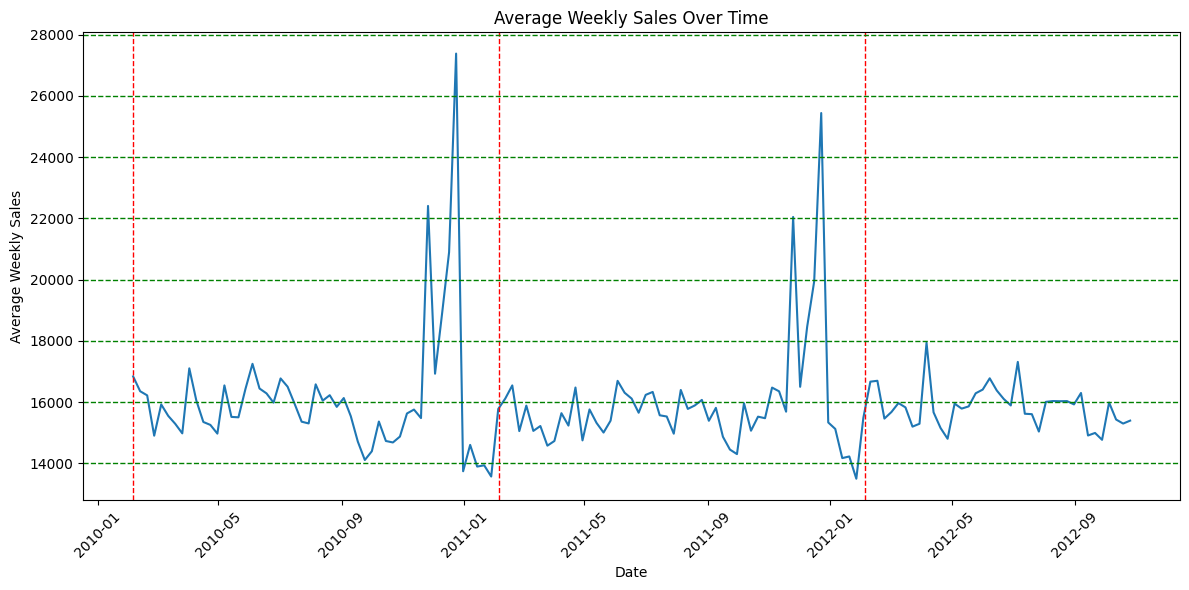

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
avg_sales_over_time = df.groupby('Date')['Weekly_Sales'].mean()

plt.figure(figsize=(12, 6))
plt.plot(avg_sales_over_time.index, avg_sales_over_time.values)
plt.xlabel('Date')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales Over Time')
plt.xticks(rotation=45)
plt.tight_layout()

# Add vertical lines for the end of each year
years = pd.to_datetime(avg_sales_over_time.index).year.unique()
for year in years:
    end_of_year = pd.to_datetime(f'{year}-02-05')
    plt.axvline(end_of_year, color='red', linestyle='--', lw=1)

for i in range(7, 15):
  plt.axhline(i * 2000, color='green', linestyle='--', lw=1)

plt.show()

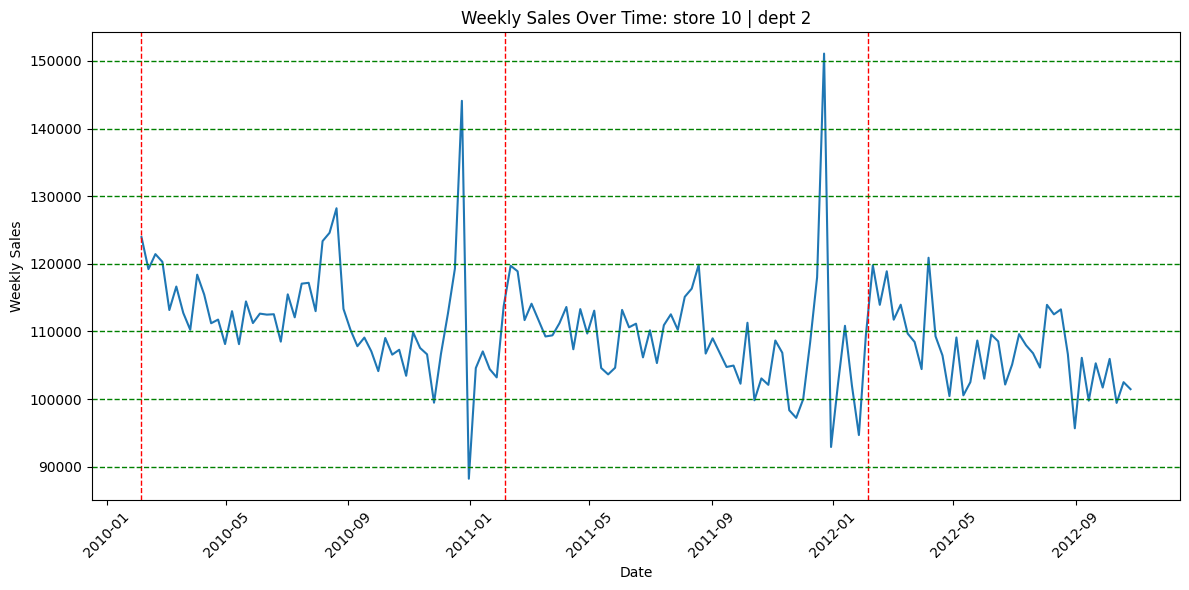

In [ ]:
store_id = 10
dept_id = 2

df['Date'] = pd.to_datetime(df['Date'])
store_dept_df = df[(df['Store'] == store_id) & (df['Dept'] == dept_id)]
store_sales_over_time = store_dept_df.groupby('Date')['Weekly_Sales'].sum()

plt.figure(figsize=(12, 6))
plt.plot(store_sales_over_time.index, store_sales_over_time.values)
plt.xlabel('Date')
plt.ylabel(f'Weekly Sales')
plt.title(f'Weekly Sales Over Time: store {store_id} | dept {dept_id}')
plt.xticks(rotation=45)
plt.tight_layout()

# Add vertical lines for the end of each year
years = pd.to_datetime(store_sales_over_time.index).year.unique()
for year in years:
    end_of_year = pd.to_datetime(f'{year}-02-05')
    plt.axvline(end_of_year, color='red', linestyle='--', lw=1)

for i in range(9, 16):
  plt.axhline(i * 10000, color='green', linestyle='--', lw=1)

plt.show()

# Remove Trend

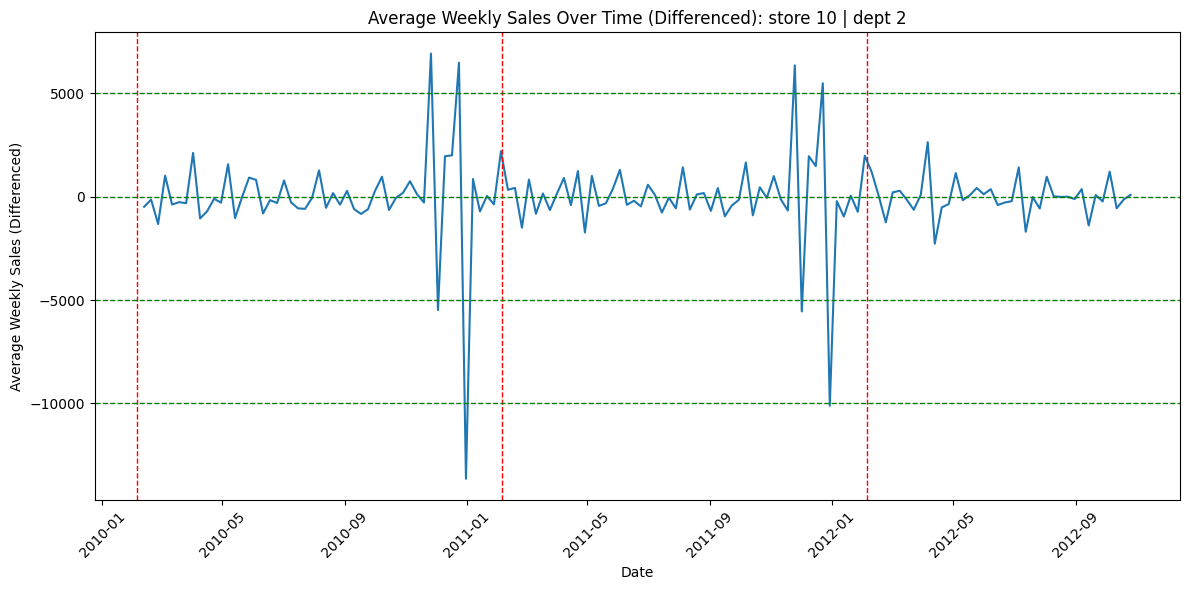

In [ ]:
avg_sales_over_time_diff = avg_sales_over_time.diff().dropna()

plt.figure(figsize=(12, 6))
plt.plot(avg_sales_over_time_diff.index, avg_sales_over_time_diff.values)
plt.xlabel('Date')
plt.ylabel(f'Average Weekly Sales (Differenced)')
plt.title(f'Average Weekly Sales Over Time (Differenced): store {store_id} | dept {dept_id}')
plt.xticks(rotation=45)
plt.tight_layout()

# Add vertical lines for the end of each year
years = pd.to_datetime(avg_sales_over_time_diff.index).year.unique()
for year in years:
    end_of_year = pd.to_datetime(f'{year}-02-05')
    plt.axvline(end_of_year, color='red', linestyle='--', lw=1)

for i in range(-2, 2):
  plt.axhline(i * 5000, color='green', linestyle='--', lw=1)

plt.show()

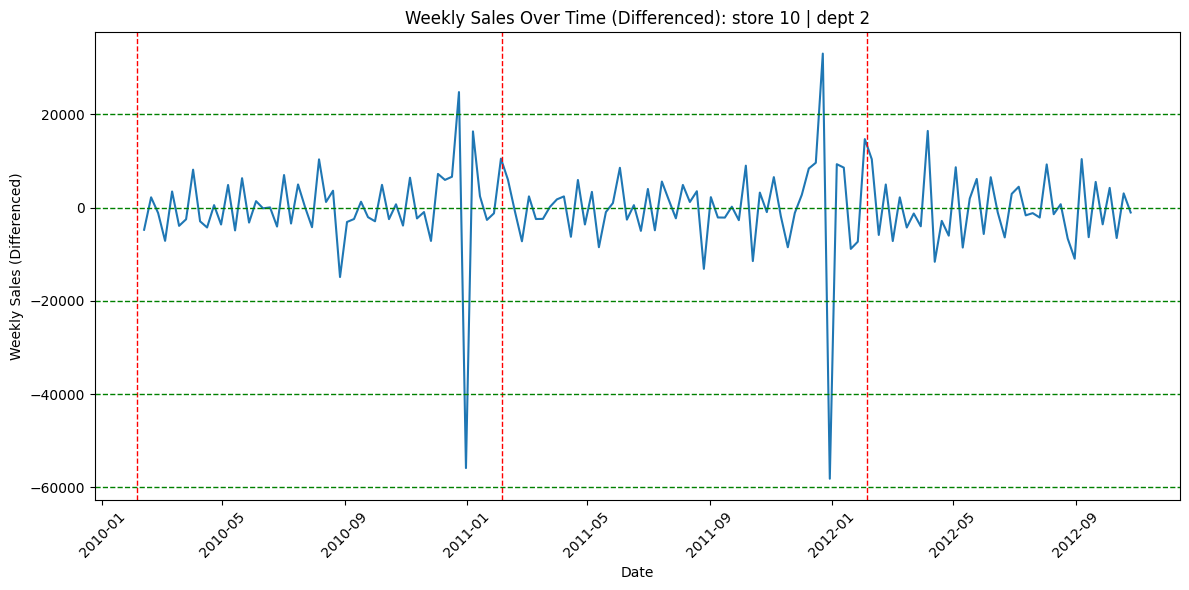

In [ ]:
store_id = 10
dept_id = 2

store_sales_over_time_diff = store_sales_over_time.diff().dropna()

plt.figure(figsize=(12, 6))
plt.plot(store_sales_over_time_diff.index, store_sales_over_time_diff.values)
plt.xlabel('Date')
plt.ylabel(f'Weekly Sales (Differenced)')
plt.title(f'Weekly Sales Over Time (Differenced): store {store_id} | dept {dept_id}')
plt.xticks(rotation=45)
plt.tight_layout()

# Add vertical lines for the end of each year
years = pd.to_datetime(store_sales_over_time_diff.index).year.unique()
for year in years:
    end_of_year = pd.to_datetime(f'{year}-02-05')
    plt.axvline(end_of_year, color='red', linestyle='--', lw=1)

for i in range(-3, 2):
  plt.axhline(i * 20000, color='green', linestyle='--', lw=1)

plt.show()

# ACF

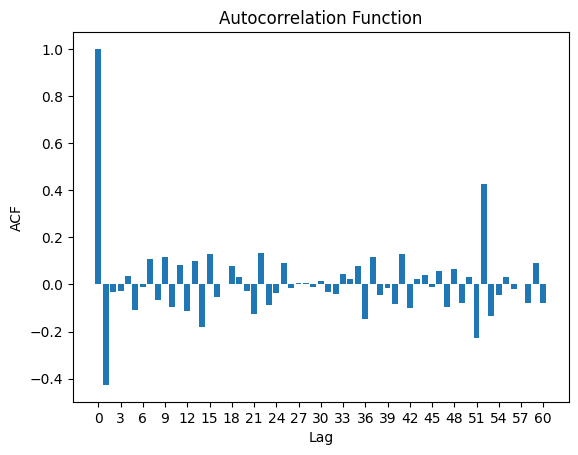

In [ ]:
acf_vals = acf(store_sales_over_time_diff, nlags=60)
num_lags = len(acf_vals)
plt.bar(range(num_lags), acf_vals[:num_lags])
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function')
plt.xticks(np.arange(0, num_lags, 3))

plt.show()

# PACF

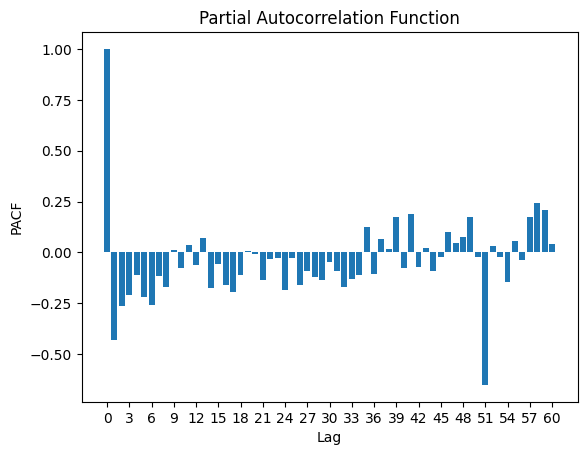

In [ ]:
pacf_vals = pacf(store_sales_over_time_diff, nlags=60)
num_lags = len(pacf_vals)
plt.bar(range(num_lags), pacf_vals[:num_lags])
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.title('Partial Autocorrelation Function')
plt.xticks(np.arange(0, num_lags, 3))

plt.show()

# Fit Model

In [ ]:
train_end_date = pd.to_datetime('2012-02-03')

df_train = df[df['Date'] < train_end_date]
df_val = df[df['Date'] >= train_end_date]

In [ ]:
# Seasonal lag is about 51-52

my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 2)

model = SARIMAX(df_train['Weekly_Sales'], order=my_order, seasonal_order=my_seasonal_order)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [ ]:
start = time()
model_fit = model.fit(method='lbfgs', maxiter=100)
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 61.63213348388672


In [ ]:
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                        Weekly_Sales   No. Observations:               305982
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 2)   Log Likelihood            -3199972.336
Date:                             Thu, 26 Jun 2025   AIC                        6399950.672
Time:                                     13:12:01   BIC                        6399982.566
Sample:                                          0   HQIC                       6399959.889
                                          - 305982                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L2       -0.7195      0.003   -211.113      0.000      -0.726      -0.713
ma.S.L2        0.6274      

In [ ]:
predictions = model_fit.forecast(len(df_val))
predictions = pd.Series(predictions, index=df_val.index)
residuals = df_val - predictions

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)